# Hierarchical Modeling: House Radon Gas

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import theano
import pymc3 as pm
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_context('notebook')
np.random.seed(12345)
rc = {'xtick.labelsize': 10, 'ytick.labelsize': 10, 'axes.labelsize': 10, 'font.size': 10, 
      'legend.fontsize': 12.0, 'axes.titlesize': 10, "figure.figsize": [14, 6]}
sns.set(rc = rc)
sns.set_style("whitegrid")

## Step 1: Prepare the data

In [2]:
data = pd.read_csv("https://raw.githubusercontent.com/pymc-devs/pymc3/master/pymc3/examples/data/radon.csv")
data.head()

Unnamed: 0   idnum state state2  stfips    zip  region  typebldg  floor  \
0           0  5081.0    MN     MN    27.0  55735     5.0       1.0    1.0   
1           1  5082.0    MN     MN    27.0  55748     5.0       1.0    0.0   
2           2  5083.0    MN     MN    27.0  55748     5.0       1.0    0.0   
3           3  5084.0    MN     MN    27.0  56469     5.0       1.0    0.0   
4           4  5085.0    MN     MN    27.0  55011     3.0       1.0    0.0   

   room    ...     pcterr        adjwt  dupflag  zipflag  cntyfips  county  \
0   3.0    ...        9.7  1146.499190      1.0      0.0       1.0  AITKIN   
1   4.0    ...       14.5   471.366223      0.0      0.0       1.0  AITKIN   
2   4.0    ...        9.6   433.316718      0.0      0.0       1.0  AITKIN   
3   4.0    ...       24.3   461.623670      0.0      0.0       1.0  AITKIN   
4   4.0    ...       13.8   433.316718      0.0      0.0       3.0   ANOKA   

      fips      Uppm  county_code  log_radon  
0  27001.0  0.502054            0   0.832909  
1  27001.0  0.502054            0   0.832909  
2  27001.0  0.502054            0   1.098612  
3  27001.0  0.502054            0   0.095310  
4  27003.0  0.428565            1   1.163151  

[5 rows x 30 columns]

In [3]:
data.shape

(919, 30)

In [4]:
data.columns

Index(['Unnamed: 0', 'idnum', 'state', 'state2', 'stfips', 'zip', 'region',
       'typebldg', 'floor', 'room', 'basement', 'windoor', 'rep', 'stratum',
       'wave', 'starttm', 'stoptm', 'startdt', 'stopdt', 'activity', 'pcterr',
       'adjwt', 'dupflag', 'zipflag', 'cntyfips', 'county', 'fips', 'Uppm',
       'county_code', 'log_radon'],
      dtype='object')

In [5]:
radon_data = data[["floor", "log_radon", "county"]]
radon_data.head()

floor  log_radon  county
0    1.0   0.832909  AITKIN
1    0.0   0.832909  AITKIN
2    0.0   1.098612  AITKIN
3    0.0   0.095310  AITKIN
4    0.0   1.163151   ANOKA

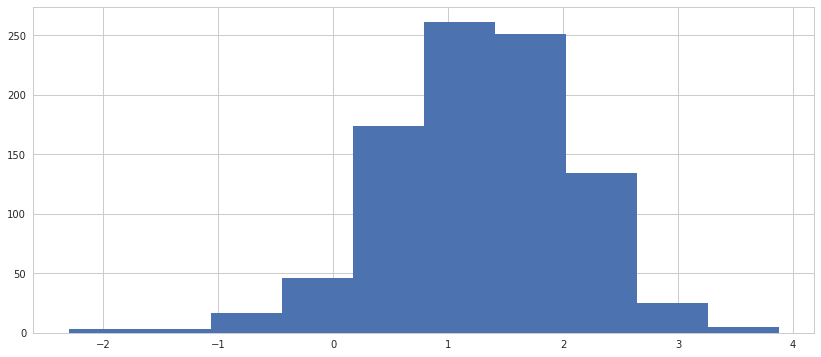

In [6]:
data["log_radon"].hist()

In [7]:
X = np.array(data["floor"])
y = np.array(data["log_radon"])

In [17]:
X[:10]

array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [18]:
y[:10]

array([ 0.83290912,  0.83290912,  1.09861229,  0.09531018,  1.16315081,
        0.95551145,  0.47000363,  0.09531018, -0.22314355,  0.26236426])

## Step 2: Build the model

### Complete Pooling

In [23]:
with pm.Model() as complete_pooled_model:
    
    # specify the priors
    slope_group = pm.Normal("slope_group", mu = 0, sd = 5)
    intercept = pm.Normal("intercept", mu = 0, sd = 5)
    error_obs = pm.HalfNormal("error_obs", sd = 5)
    
    # specify the mean function
    mean_group = intercept + slope_group * X
    
    # specify the likelihood of the data
    obs = pm.Normal("obs", mu = mean_group, sd = error_obs, observed = y)

### Hierarchical modeling

In [ ]:
with pm.Model() as hierarchical_model:
    
    # specify priori
    mean_group = pm.Normal("mean_group", mu = 0, sd = 5)
    sd_mean_house = pm.HalfNormal("error_mean_house", sd = 5)
    sd_obs = pm.HalfNormal("sd_obs", sd = 5)
    
    slope_mean_house = pm.Normal("slope_mean_house", mu = 0, sd = 5, shape = len(y))
    intercept_mean_house = pm.Normal("intercept_mean_house", mu = 0, sd = 5, shape = len(y))
    
    # specify the mean functions
    mean_house = intercept_mean_house + slope_mean_house * X
    
    # specify the data likelihood
    obs = pm.Normal("obs", mu = mean_house, sd = sd_obs, observed = y, shape = len(y))    

## Step 3: Sample from the posterior

In [ ]:
with complete_pooled_model:
    step = pm.NUTS(target_accept = 0.9)
    posterior_complete_pooled = pm.sample(draws = 500, njobs = 2)

## Step 4: Diagnose the convergence of MCMC chains

In [ ]:
pm.traceplot(posterior_complete_pooled)

In [21]:
pm.gelman_rubin(posterior_complete_pooled)

{'error_obs': 0.99750623433125873,
 'intercept': 0.99820842969822043,
 'slope_group': 0.99783496317367448}

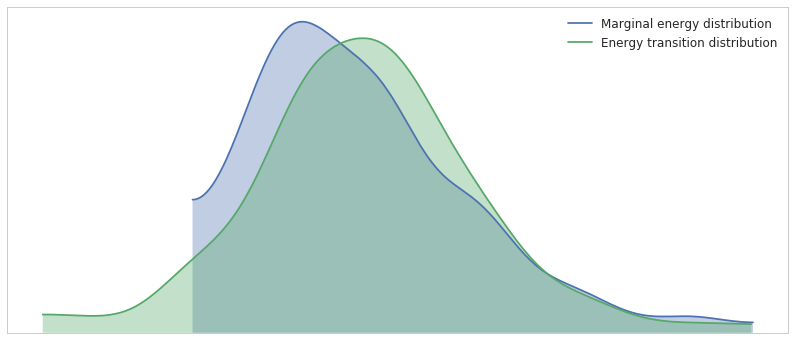

In [24]:
pm.energyplot(posterior_complete_pooled)

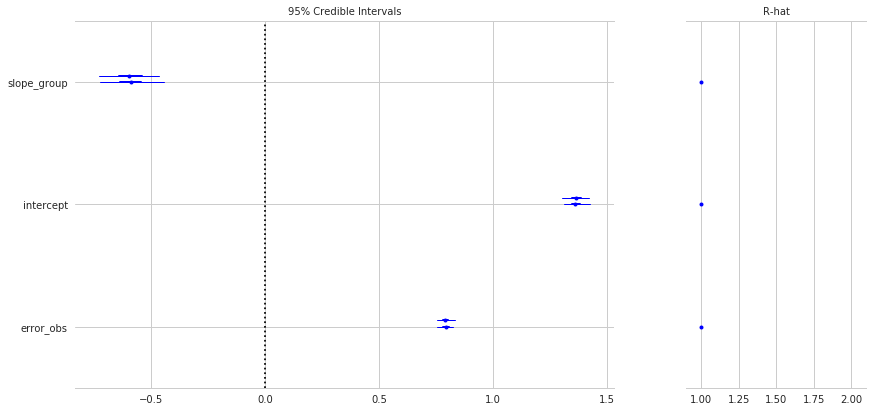

In [25]:
pm.forestplot(posterior_complete_pooled)

## Step 5: Criticize the model

In [26]:
pm.summary(posterior_complete_pooled)


slope_group:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  -0.590           0.070            0.003            [-0.724, -0.450]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  -0.725         -0.636         -0.589         -0.541         -0.451


intercept:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  1.362            0.030            0.001            [1.299, 1.417]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  1.303          1.344          1.362          1.383          1.423


error_obs:

  Mean             SD               MC Error         95% HPD interval
  --------

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f7f1a57c9e8>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7f7f1a4b46a0>], dtype=object)

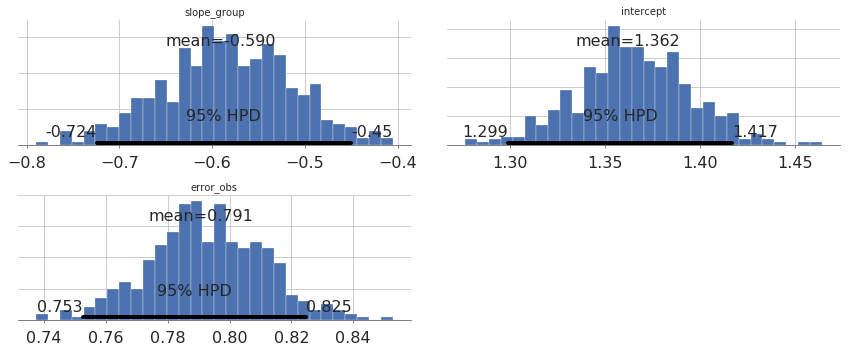

In [27]:
pm.plot_posterior(posterior_complete_pooled)